**52100674_52100878_52100322**
* Trần Thị Vẹn
* Nguyễn Đình Danh
* Trương Bình Thuận


Bài 1 (5đ):
Tìm hiểu và trình bày về các biểu diễn token theo phương pháp BPE  (Byte-Pair Encoding). 
Cho các ví dụ về các mô hình có sử dụng tokenizer theo BPE.
***
* So sánh 2 mô hình trên một bài toán cụ thể nào đó có sử dụng BPE và không sử dụng BPE. 
* Lưu ý 2 mô hình này phải được train và test trên cùng một bộ dữ liệu.***

Để so sánh hai mô hình trên một bài toán cụ thể với việc sử dụng BPE (Byte Pair Encoding) và không sử dụng BPE, 
chúng ta có thể sử dụng GPT-2 cho mô hình thứ hai. 
***
* LSTM Model (Không sử dụng BPE): huấn luyện trên dữ liệu ký tự đơn lẻ.
* GPT-2 Model (Sử dụng BPE): Sử dụng GPT-2 với tokenizer BPE.
****

Thuộc tính normalizer của đối tượng tokenizer có phương thức normalize_str() mà ta có thể dùng để thấy cách bước chuẩn hoá được thực hiện:

In [77]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

In [79]:
#Tiếp theo, ta cần tiền tokenize kho ngữ liệu này thành các từ. Vì ta đang sao chép một bản BPE tokenizer (như GPT-2), ta vẫn có thể sử dụng gpt2 tokenize cho bước pre-tokenization:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [80]:
#Sau đó ta tính tần suất của từng từ trong kho ngữ liệu như khi làm với pre-tokenization:
from collections import defaultdict

word_freqs = defaultdict(int)

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

defaultdict(<class 'int'>, {'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, '.': 4, 'Ġchapter': 1, 'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})


In [81]:
#Tiếp theo chúng ta sẽ tính bộ từ vựng cơ sở từ các kí tự sử dụng trong kho ngữ liệu:

alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(alphabet)

[',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


In [83]:
#Ta cũng có thể thêm các token đặc biệt từ mô hình ở đầu của bộ tự vựng. Trong trường hợp của GPT-2, token đặc biệt duy nhất đó là "<|endoftext|>":
vocab = ["<|endoftext|>"] + alphabet.copy()

In [84]:
#Ta giờ cần phải chia mỗi từ thành các kí tự riêng lẻ để có thể bắt đầu huấn luyện
splits = {word: [c for c in word] for word in word_freqs.keys()}

In [85]:
#Giờ ta đã sẵn sàng để huấn luyện, hãy cùng viết một hàm tính tần suất mỗi cặp. Ta sẽ cần sử dụng nó ở bước huấn luyện:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

In [86]:
#Hãy nhìn vào một phần từ điẻn sau khi tách:
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('T', 'h'): 3
('h', 'i'): 3
('i', 's'): 5
('Ġ', 'i'): 2
('Ġ', 't'): 7
('t', 'h'): 3


In [87]:
#Giờ thì, tìm xem cặp xuất hiện nhiều nhất bằng một vòng lặp nhanh:

best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

('Ġ', 't') 7


In [88]:
#Vậy phép hợp nhất đầu tiên là ('Ġ', 't') -> 'Ġt', và ta thêm 'Ġt' vào bộ từ vựng:
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

In [90]:
#Để tiếp tục, ta cần áp dụng sự hợp nhất ở từ điển splits. Hãy cùng viết một hàm khác cho nó:

def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [91]:
#Giờ ta có thể nhìn xem kết quả của lần hợp nhất đầu tiên:
splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


In [92]:
#Giờ thì ta có tất cả những gì mình cần để lặp cho đến khi ta học tất các các hợp nhất mà ta muốn. Hãy cũng nhắm tới bộ tự vựng có kích cỡ là 50:

vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

In [93]:
#Kết quả là, chúng ta đã học 19 quy tắc hợp nhất (bộ từ điển gốc có kích cỡ là 31 tương ứng 30 kí tự trong bảng chữ cái cùng một token đặt biệt):

print(merges)

{('Ġ', 't'): 'Ġt', ('i', 's'): 'is', ('e', 'r'): 'er', ('Ġ', 'a'): 'Ġa', ('Ġt', 'o'): 'Ġto', ('e', 'n'): 'en', ('T', 'h'): 'Th', ('Th', 'is'): 'This', ('o', 'u'): 'ou', ('s', 'e'): 'se', ('Ġto', 'k'): 'Ġtok', ('Ġtok', 'en'): 'Ġtoken', ('n', 'd'): 'nd', ('Ġ', 'is'): 'Ġis', ('Ġt', 'h'): 'Ġth', ('Ġth', 'e'): 'Ġthe', ('i', 'n'): 'in', ('Ġa', 'b'): 'Ġab', ('Ġtoken', 'i'): 'Ġtokeni'}


In [94]:
print(vocab)

['<|endoftext|>', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ', 'Ġt', 'is', 'er', 'Ġa', 'Ġto', 'en', 'Th', 'This', 'ou', 'se', 'Ġtok', 'Ġtoken', 'nd', 'Ġis', 'Ġth', 'Ġthe', 'in', 'Ġab', 'Ġtokeni']


Sử dụng train_new_from_iterator() trên cùng kho ngữ liệu sẽ không mang về kết quả kho ngữ liệu y hệt. 
Đó là bởi khi có sự lựa chọn về cặp có tần suất cao nhất, ta đã chọn cái đầu tiên xuất hiện, 
trong khi thư viện Tokenizers chọn cái đầu tiên dựa trên ID bên trong của nó.

In [95]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])
#Ta có thể thử các này với bất kì đoạn văn nào khác được tạo thành từ các kí tự trong bảng chữ cái:
tokenize("This is not a token.")

['This', 'Ġis', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']

# GPT2 : BPE, WordLevel

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from transformers import GPT2LMHeadModel, AdamW, GPT2Tokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
import matplotlib.pyplot as plt

In [3]:
# Training parameters
n_epochs = 30
batch_size = 2
learning_rate = 5e-5
chunk_size = 512

def train_model(model, tokenizer, dataset, device, n_epochs, batch_size, learning_rate):
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.logits, -1)
            total += input_ids.numel()
            correct += (predicted == input_ids).sum().item()

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
                loss = outputs.loss
                val_loss += loss.item()
                _, predicted = torch.max(outputs.logits, -1)
                total += input_ids.numel()
                correct += (predicted == input_ids).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_loss / len(train_loader):.4f}, Train Acc: {correct / total:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {correct / total:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [4]:
def generate_text(model, tokenizer, prompt, max_length=100, num_return_sequences=3):
    model.eval()
    encoded_prompt = tokenizer.encode(prompt, return_tensors='pt').to(device)
    attention_mask = torch.ones(encoded_prompt.shape, device=device)
    outputs = model.generate(
        input_ids=encoded_prompt,
        attention_mask=attention_mask,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        pad_token_id=tokenizer.eos_token_id
    )
    generated_texts = []
    for output in outputs:
        generated_text = tokenizer.decode(output, skip_special_tokens=True)
        generated_texts.append(generated_text)
    return generated_texts

In [7]:
# Load text data
filename = "/kaggle/input/datain5/alice13a.txt"
with open(filename, 'r', encoding='utf-8') as file:
    text = file.read().lower()

# Training and evaluating the WordLevel tokenizer model
special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
tokenizer = Tokenizer(models.WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.WordLevelTrainer(vocab_size=5000, special_tokens=special_tokens)
tokenizer.train_from_iterator([text], trainer)
tokenizer.save("wordlevel_tokenizer.json")
tokenizer = Tokenizer.from_file("wordlevel_tokenizer.json")

chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
encoded = [tokenizer.encode(chunk) for chunk in chunks]
input_ids = [torch.tensor(encode.ids) for encode in encoded]
attention_masks = [torch.tensor(encode.attention_mask) for encode in encoded]

input_ids = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.token_to_id("[PAD]"))
attention_masks = nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)

class TextDataset(data.Dataset):
    def __init__(self, input_ids, attention_masks):
        self.input_ids = input_ids
        self.attention_mask = attention_masks

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {'input_ids': self.input_ids[idx], 'attention_mask': self.attention_mask[idx]}

dataset = TextDataset(input_ids, attention_masks)
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer.get_vocab()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses_WL, val_losses_WL, train_accuracies_WL, val_accuracies_WL = train_model(model, tokenizer, dataset, device, n_epochs, batch_size, learning_rate)
torch.save(model.state_dict(), 'gpt2_model_WL.pth')

Epoch 1/30, Train Loss: 4.7560, Train Acc: 0.2231, Val Loss: 4.4004, Val Acc: 0.2231
Epoch 2/30, Train Loss: 4.1658, Train Acc: 0.2224, Val Loss: 4.1767, Val Acc: 0.2224
Epoch 3/30, Train Loss: 3.8316, Train Acc: 0.2224, Val Loss: 4.0670, Val Acc: 0.2224
Epoch 4/30, Train Loss: 3.4618, Train Acc: 0.2228, Val Loss: 4.0795, Val Acc: 0.2228
Epoch 5/30, Train Loss: 2.9613, Train Acc: 0.2224, Val Loss: 4.2547, Val Acc: 0.2224
Epoch 6/30, Train Loss: 2.2923, Train Acc: 0.2224, Val Loss: 4.5809, Val Acc: 0.2224
Epoch 7/30, Train Loss: 1.4272, Train Acc: 0.2227, Val Loss: 5.5224, Val Acc: 0.2227
Epoch 8/30, Train Loss: 0.7019, Train Acc: 0.2228, Val Loss: 6.3869, Val Acc: 0.2228
Epoch 9/30, Train Loss: 0.3195, Train Acc: 0.2228, Val Loss: 6.8566, Val Acc: 0.2228
Epoch 10/30, Train Loss: 0.1649, Train Acc: 0.2225, Val Loss: 7.0555, Val Acc: 0.2225
Epoch 11/30, Train Loss: 0.1117, Train Acc: 0.2233, Val Loss: 7.1322, Val Acc: 0.2233
Epoch 12/30, Train Loss: 0.0941, Train Acc: 0.2229, Val Loss: 7

In [8]:
# Training and evaluating the GPT-2 tokenizer model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))
model.to(device)

chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
input_ids = []
attention_masks = []
for chunk in chunks:
    tokens = tokenizer(chunk, return_tensors="pt", max_length=chunk_size, truncation=True, padding="max_length")
    input_ids.append(tokens['input_ids'])
    attention_masks.append(tokens['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

dataset = TextDataset(input_ids, attention_masks)
train_losses_GPT2, val_losses_GPT2, train_accuracies_GPT2, val_accuracies_GPT2 = train_model(model, tokenizer, dataset, device, n_epochs, batch_size, learning_rate)
torch.save(model.state_dict(), 'gpt2_model.pth')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Epoch 1/30, Train Loss: 2.3256, Train Acc: 0.7150, Val Loss: 1.1383, Val Acc: 0.7150
Epoch 2/30, Train Loss: 1.0158, Train Acc: 0.7114, Val Loss: 0.9508, Val Acc: 0.7114
Epoch 3/30, Train Loss: 0.8881, Train Acc: 0.7102, Val Loss: 0.8995, Val Acc: 0.7102
Epoch 4/30, Train Loss: 0.8163, Train Acc: 0.7102, Val Loss: 0.8714, Val Acc: 0.7102
Epoch 5/30, Train Loss: 0.7661, Train Acc: 0.7093, Val Loss: 0.8626, Val Acc: 0.7093
Epoch 6/30, Train Loss: 0.7173, Train Acc: 0.7099, Val Loss: 0.8611, Val Acc: 0.7099
Epoch 7/30, Train Loss: 0.6719, Train Acc: 0.7091, Val Loss: 0.8577, Val Acc: 0.7091
Epoch 8/30, Train Loss: 0.6263, Train Acc: 0.7093, Val Loss: 0.8706, Val Acc: 0.7093
Epoch 9/30, Train Loss: 0.5788, Train Acc: 0.7068, Val Loss: 1.1722, Val Acc: 0.7068
Epoch 10/30, Train Loss: 0.6600, Train Acc: 0.7092, Val Loss: 0.8926, Val Acc: 0.7092
Epoch 11/30, Train Loss: 0.5467, Train Acc: 0.7101, Val Loss: 0.9370, Val Acc: 0.7101
Epoch 12/30, Train Loss: 0.4683, Train Acc: 0.7096, Val Loss: 0

Text(0.5, 1.0, 'Training and Validation Loss')

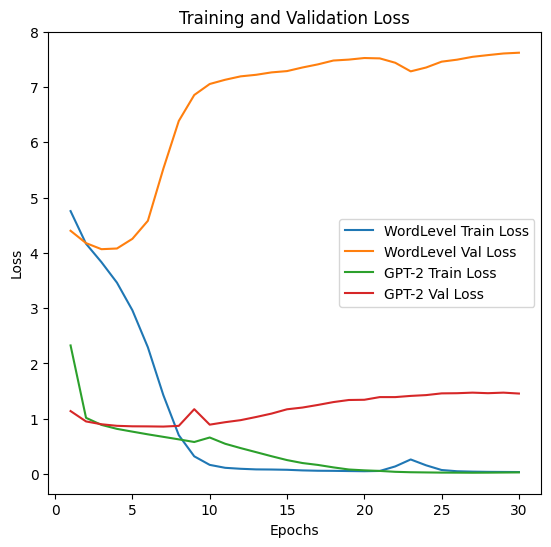

In [9]:
# Plotting the results
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_WL, label='WordLevel Train Loss')
plt.plot(epochs, val_losses_WL, label='WordLevel Val Loss')
plt.plot(epochs, train_losses_GPT2, label='GPT-2 Train Loss')
plt.plot(epochs, val_losses_GPT2, label='GPT-2 Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')


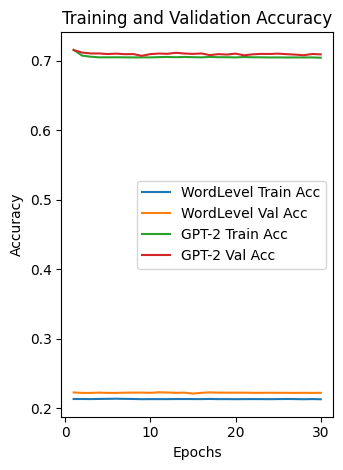

In [10]:
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_WL, label='WordLevel Train Acc')
plt.plot(epochs, val_accuracies_WL, label='WordLevel Val Acc')
plt.plot(epochs, train_accuracies_GPT2, label='GPT-2 Train Acc')
plt.plot(epochs, val_accuracies_GPT2, label='GPT-2 Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [16]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tokenizers import Tokenizer

def generate_text(model, tokenizer, prompt, max_length, num_return_sequences):
    if isinstance(tokenizer, GPT2Tokenizer):
        encoded_input = tokenizer.encode(prompt, return_tensors='pt').to(model.device)
    else:
        # Manually encode for WordLevel tokenizer
        encoded_input = torch.tensor([tokenizer.encode(prompt).ids]).to(model.device)
    
    attention_mask = torch.ones(encoded_input.shape, device=model.device)
    outputs = model.generate(
        input_ids=encoded_input,
        attention_mask=attention_mask,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        pad_token_id=tokenizer.eos_token_id if isinstance(tokenizer, GPT2Tokenizer) else 0  # assuming eos_token_id is 0 for WordLevel tokenizer
    )
    generated_texts = [tokenizer.decode(output, skip_special_tokens=True) if isinstance(tokenizer, GPT2Tokenizer) else tokenizer.decode(output.tolist(), skip_special_tokens=True) for output in outputs]
    return generated_texts

# Example text generation with WordLevel Tokenizer Model
prompt = "Alice"
# Reload the WordLevel tokenizer and model
wordlevel_tokenizer = Tokenizer.from_file("wordlevel_tokenizer.json")

# Assuming the custom tokenizer's length is the same as the saved model's length
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(wordlevel_tokenizer.get_vocab()))
model.load_state_dict(torch.load('gpt2_model_WL.pth'))
model.eval()

print("WordLevel Tokenizer Model Generated Texts:")
generated_texts_WL = generate_text(model, wordlevel_tokenizer, prompt, max_length=100, num_return_sequences=1)
for i, text in enumerate(generated_texts_WL):
    print(f"Generated Text {i+1}:\n{text}\n")

# Example text generation with GPT-2 Tokenizer Model
# Reload the GPT-2 tokenizer and model
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(gpt2_tokenizer))
model.load_state_dict(torch.load('gpt2_model.pth'))
model.eval()

print("GPT-2 Tokenizer Model Generated Texts:")
generated_texts_GPT2 = generate_text(model, gpt2_tokenizer, prompt, max_length=100, num_return_sequences=1)
for i, text in enumerate(generated_texts_GPT2):
    print(f"Generated Text {i+1}:\n{text}\n")


WordLevel Tokenizer Model Generated Texts:
Generated Text 1:
the question ?' said the lory . alice replied eagerly , for she was always ready to talk about her pet : ` dinah ' s our cat . and she ' s such a capital one for catching mice you can ' t think ! and oh , i wish you could see her after the birds ! why , she ' ll eat a little bird as soon as look at it !' this speech caused a remarkable sensation among the party . some of the birds hurried off at once : one the old magpie began

GPT-2 Tokenizer Model Generated Texts:
Generated Text 1:
Alice 
to beautify!' 
 
  `how do you know it?' said alice, who always 
looked so pretty in the comedownie of her face when she smiled 
at those roses that had just fallen from the sky. 
 
  `you shouldn't look so pretty,' said alice; `i'm sure it's 
essential in the game to lookaholic.  beien

